In [1]:
!pip install catboost xgboost

In [2]:
import os
print(os.listdir('.'))

['__notebook__.ipynb']


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [4]:
data_df = pd.read_csv("/kaggle/input/selected-data-imdb/data_selected.csv")
X = data_df.drop('Rating', axis=1)
Y = data_df['Rating']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [5]:
print("Training shape (X, Y):", X_train.shape, y_train.shape)
# print("Validation shape (X, Y):", X_val.shape, y_val.shape)
print("Test shape (X, Y):", X_test.shape, y_test.shape)

Training shape (X, Y): (17718, 16) (17718,)
Test shape (X, Y): (7594, 16) (7594,)


In [6]:
def get_accuracy_details(model, X,y):
    """
    Calculates and prints accuracy details for a given model using provided features and target data.

    Args:
        model: A trained machine learning model with `predict` and `score` methods.
        X: Features data used for making predictions.
        y: True target values corresponding to the features.

    Prints:
        Validation R² score: Coefficient of determination of the prediction.
        Validation Mean Squared Error: Mean of the squared differences between predicted and true values.
        Validation Mean Absolute Error: Mean of the absolute differences between predicted and true values.
    """

    y_pred = model.predict(X)

    # Calculate R² score
    r2_score = model.score(X, y)

    from sklearn.metrics import mean_squared_error, mean_absolute_error
    val_mse = mean_squared_error(y, y_pred)
    val_mae = mean_absolute_error(y, y_pred)

    print(f"Validation R² score: {r2_score}")
    print(f"Validation Mean Squared Error: {val_mse}")
    print(f"Validation Mean Absolute Error: {val_mae}")

In [7]:
from sklearn.model_selection import GridSearchCV

In [8]:
from sklearn.ensemble import RandomForestRegressor

def train_random_forest(X_train, y_train):
    param_grid = {
        'n_estimators': [500, 800],
        'max_depth': [10, 15],
    }
    rf_regressor = RandomForestRegressor(random_state=42)
    grid_search = GridSearchCV(rf_regressor, param_grid, cv=5, scoring='r2', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    best_rf_model = grid_search.best_estimator_

    return best_rf_model, best_params

best_rf_model, best_params_rf = train_random_forest(X_train, y_train)
print(f"Random Forest - Best Parameters: {best_params_rf}")
get_accuracy_details(best_rf_model, X_test, y_test)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Random Forest - Best Parameters: {'max_depth': 15, 'n_estimators': 800}
Validation R² score: 0.7785887933767235
Validation Mean Squared Error: 0.2921084288964861
Validation Mean Absolute Error: 0.38259951629140987


In [9]:
from sklearn.neural_network import MLPRegressor

def train_mlp(X_train, y_train):
    param_grid = {
        'hidden_layer_sizes': [(32, 256, 1024, 1024, 256, 32), (32, 256, 1024, 1024, 1024, 256, 32)],
        'activation': ['relu'],
        'solver': ['adam'],
        'alpha': [0.01],
        'learning_rate_init': [0.1]
    }
    mlp_regressor = MLPRegressor(random_state=42, max_iter=200, early_stopping=True, batch_size=1024)
    grid_search = GridSearchCV(mlp_regressor, param_grid, cv=5, scoring='r2', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    best_mlp_model = grid_search.best_estimator_

    return best_mlp_model, best_params

best_mlp_model, best_params_mlp = train_mlp(X_train, y_train)
print(f"MLP - Best Parameters: {best_params_mlp}")

print("MLP Model Performance on Test Set:")
get_accuracy_details(best_mlp_model, X_test, y_test)

MLP - Best Parameters: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (64, 64), 'learning_rate_init': 0.1, 'solver': 'adam'}
MLP Model Performance on Test Set:
Validation R² score: -332139953.76676273
Validation Mean Squared Error: 438193178.38661474
Validation Mean Absolute Error: 3930.965809990557


In [10]:
import xgboost as xgb

def train_xgboost(X_train, y_train):
    param_grid = {
        'n_estimators': [500, 800],
        'learning_rate': [0.1, 1],
        'max_depth': [15, 10],
    }
    xgb_regressor = xgb.XGBRegressor(device="cuda", random_state=42, objective='reg:squarederror')
    grid_search = GridSearchCV(xgb_regressor, param_grid, cv=5, scoring='r2', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    best_xgb_model = grid_search.best_estimator_

    return best_xgb_model, best_params

best_xgb_model, best_params_xgb = train_xgboost(X_train, y_train)
print(f"XGBoost - Best Parameters: {best_params_xgb}")

print("XGBoost Model Performance on Test Set:")
get_accuracy_details(best_xgb_model, X_test, y_test)


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


XGBoost - Best Parameters: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 500}
XGBoost Model Performance on Test Set:
Validation R² score: 0.7856608072963843
Validation Mean Squared Error: 0.28277830100137424
Validation Mean Absolute Error: 0.3764898447943071


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [21:33:36] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


In [11]:
from catboost import CatBoostRegressor

def train_catboost(X_train, y_train):
    param_grid = {
        'iterations': [500, 800],
        'learning_rate': [0.1, 1],
        'depth': [10, 15]
    }
    cb_regressor = CatBoostRegressor(random_seed=29, verbose=0, task_type="GPU", devices='0')
    grid_search = GridSearchCV(cb_regressor, param_grid, cv=5, scoring='r2')
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    best_cb_model = grid_search.best_estimator_
    
    return best_cb_model, best_params

best_cb_model, best_params_cb = train_catboost(X_train, y_train)
print(f"CatBoost - Best Parameters: {best_params_cb}")
get_accuracy_details(best_cb_model, X_test, y_test)

CatBoost - Best Parameters: {'depth': 10, 'iterations': 800, 'learning_rate': 0.1}
Validation R² score: 0.7924893084352158
Validation Mean Squared Error: 0.2737694402042973
Validation Mean Absolute Error: 0.36956934358353405


KeyError: 'R2'

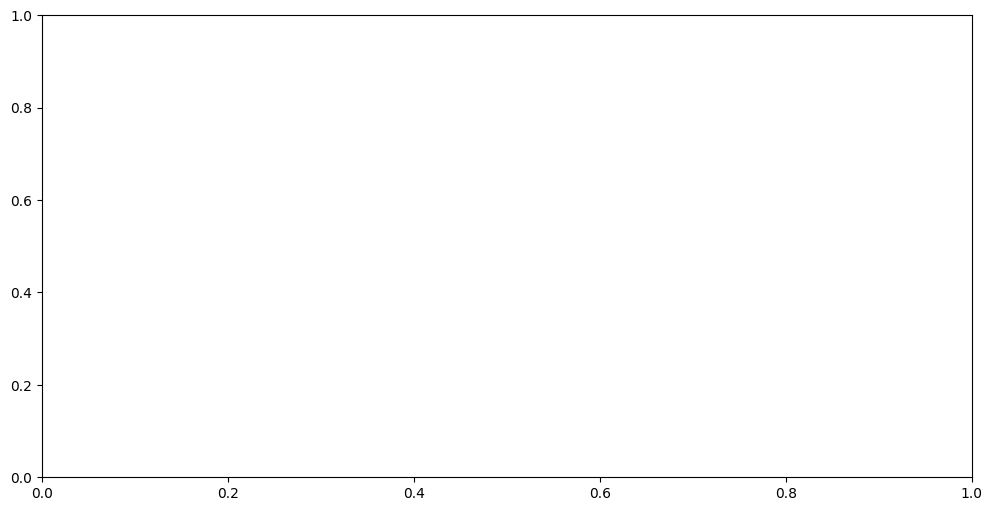

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Collect the performance metrics
metrics = {}

def collect_metrics(model, name, X_test, y_test):
    y_pred = model.predict(X_test)
    r2 = model.score(X_test, y_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    metrics[name] = {'R²': r2, 'MSE': mse, 'MAE': mae}

collect_metrics(best_cb_model, 'CatBoost', X_test, y_test)
collect_metrics(best_rf_model, 'Random Forest', X_test, y_test)
collect_metrics(best_mlp_model, 'MLP', X_test, y_test)
collect_metrics(best_xgb_model, 'XGBoost', X_test, y_test)

# Visualize the metrics (Improved with color palette and log scale for MSE)
metric_names = ['R2', 'MSE', 'MAE']
model_names = list(metrics.keys())

# --- Create the plot ---
fig, ax = plt.subplots(figsize=(12, 6))

# --- Bar width and positions ---
bar_width = 0.2
x = np.arange(len(metric_names))

# --- Color Palette ---
colors = plt.cm.Set2(np.linspace(0, 1, len(model_names)))  # Using a colormap

# --- Plotting the bars for each model ---
for i, model_name in enumerate(model_names):
    metric_values = [metrics[model_name][metric] for metric in metric_names]
    rects = ax.bar(x + i * bar_width, metric_values, bar_width, label=model_name, color=colors[i])
    ax.bar_label(rects, padding=3, fmt='%.3f')

# --- Customize the plot ---
ax.set_xlabel('Metrics', fontweight='bold')
ax.set_ylabel('Value', fontweight='bold')
ax.set_title('Model Comparison - Performance Metrics', fontweight='bold', fontsize=14)
ax.set_xticks(x + bar_width * (len(model_names) - 1) / 2)
ax.set_xticklabels(metric_names)
ax.legend()

# --- Log Scale for MSE ---
ax.set_yscale('log')  # Apply log scale to the entire y-axis
# OR, create a separate y-axis for MSE:
# ax2 = ax.twinx()
# ax2.set_ylabel('MSE (log scale)', color='tab:red')
# ax2.set_yscale('log')
# Plot MSE bars on ax2 using a different color if needed

# --- Adjust layout and display ---
fig.tight_layout()
plt.show()

In [ ]:
# --- Save the model (JSON format) ---
best_xgb_model.save_model("xgboost_model.json")

In [ ]:
# --- Save the model (JSON format) ---
best_cb_model.save_model("catboost_model.json")